In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

import sys
from pathlib import Path

project_root = Path.cwd().parent.parent
sys.path.append(str(project_root))
from ingest.ohlcv import get_connection

We establish a database connection, load price data, select a single ticker, resample to business-day frequency (Mon–Fri), and forward-fill missing values.

In [2]:
with get_connection() as conn:
    df = pd.read_sql("SELECT * FROM ohlcv", conn)

df = df[df["ticker"] == "BBVA.MC"]
df = df.reset_index(drop=True)
df["date"] = pd.to_datetime(df["date"])
df = df.set_index("date")
df = df.asfreq("B")
df["close"] = df["close"].ffill()
df.head(1)

,ticker,open,high,low,close,volume
date,,,,,,
2021-01-05,BBVA.MC,4.04,4.093,4.022,4.074,10364379.0


In [3]:
prices = df["close"]
log_returns = np.log(prices).diff().dropna()

In [4]:
p,d,q = 0,0,0
model = ARIMA(log_returns, order=(p,d,q))
model_fit = model.fit()
model_summary = model_fit.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                 1308
Model:                          ARIMA   Log Likelihood                3299.294
Date:                Wed, 14 Jan 2026   AIC                          -6594.588
Time:                        14:23:26   BIC                          -6584.235
Sample:                    01-06-2021   HQIC                         -6590.704
                         - 01-09-2026                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      2.226      0.026       0.000       0.002
sigma2         0.0004   9.13e-06     41.337      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):               736.73
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                            -0.54
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

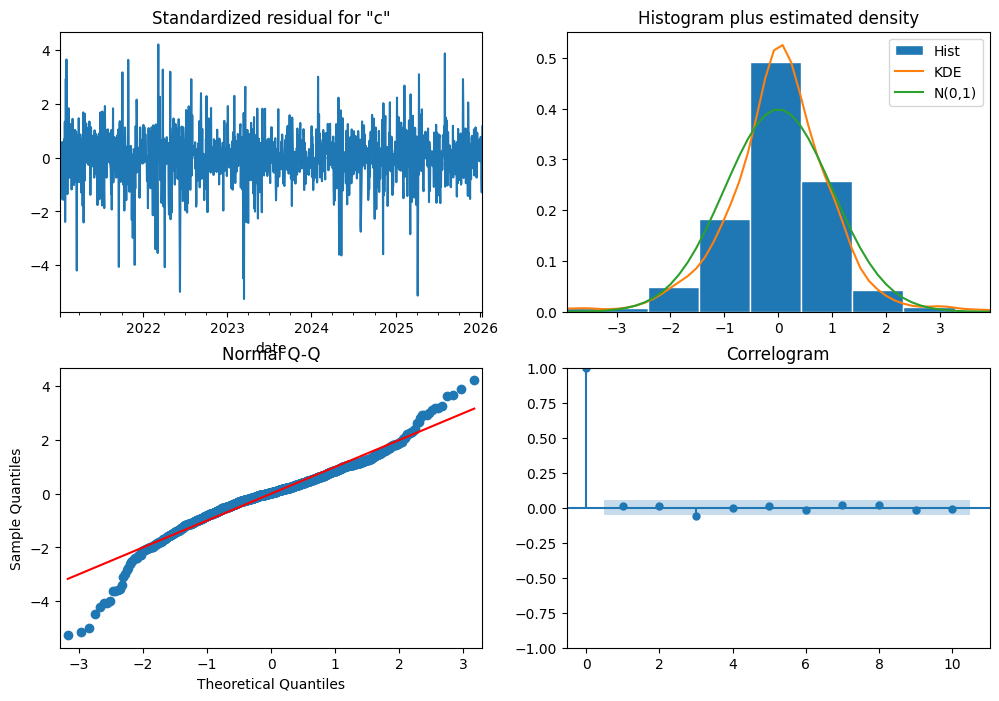

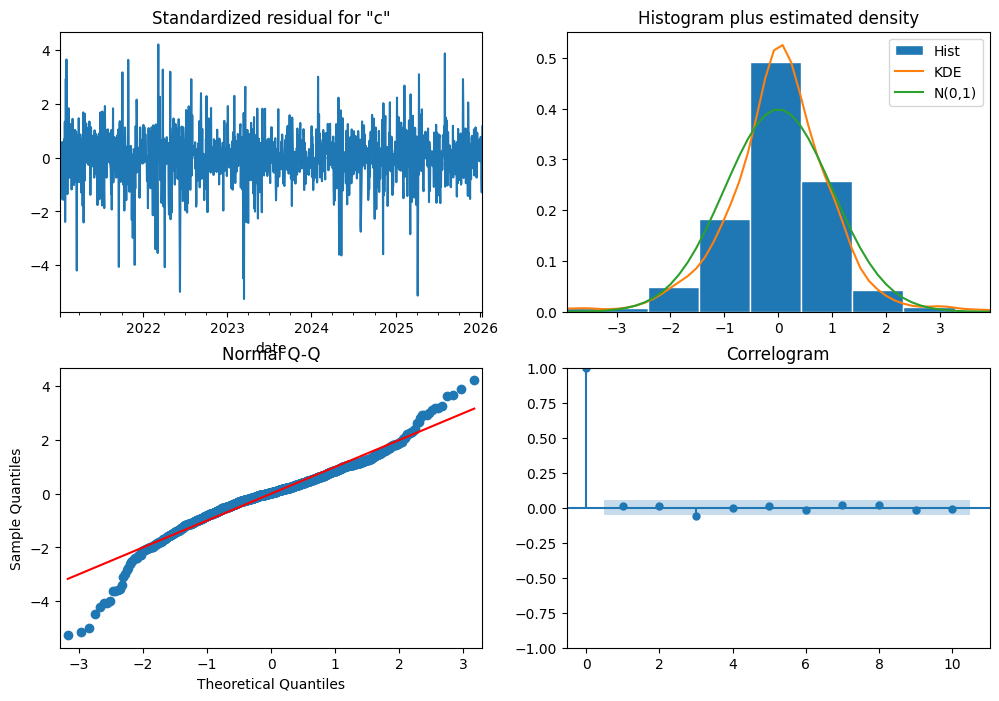

In [5]:
model_fit.plot_diagnostics(figsize=(12,8))

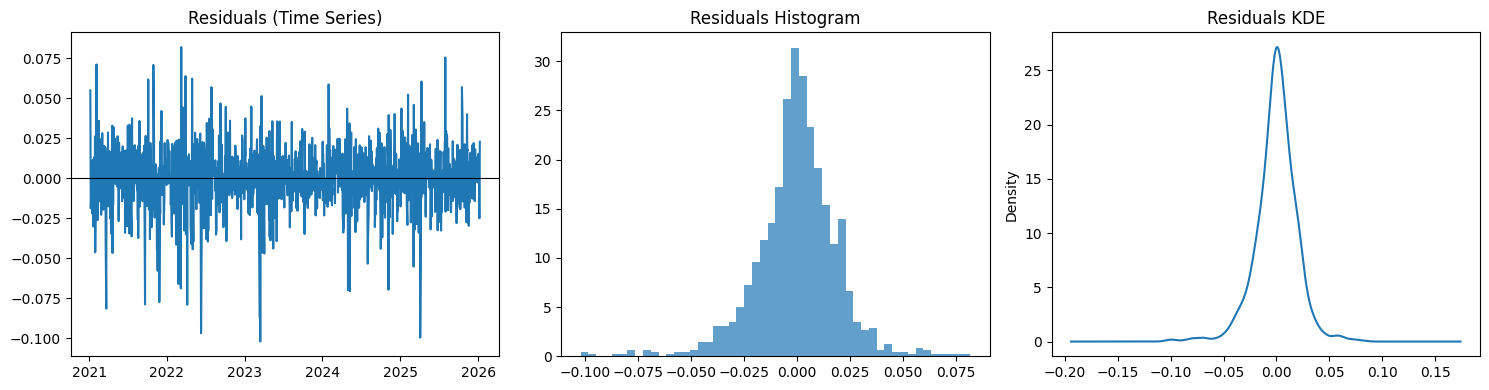

In [6]:
residuals = model_fit.resid

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(residuals)
axes[0].set_title("Residuals (Time Series)")
axes[0].axhline(0, color="black", linewidth=0.8)

axes[1].hist(residuals, bins=50, density=True, alpha=0.7)
axes[1].set_title("Residuals Histogram")

residuals.plot(kind="kde", ax=axes[2])
axes[2].set_title("Residuals KDE")

plt.tight_layout()
plt.show()


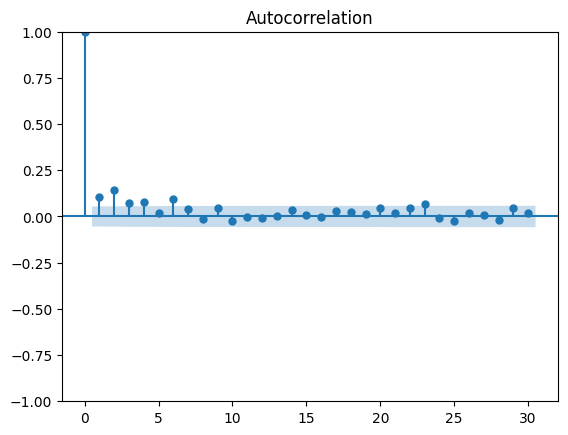

In [7]:
# plot residuals
plot_acf(residuals**2, lags=30)
plt.show()

In [8]:
from statsmodels.stats.diagnostic import het_arch

arch_test = het_arch(residuals)
arch_test


(np.float64(58.977913362289875),
 np.float64(5.6544229891296016e-09),
 6.1261679929569715,
 3.5718425494600313e-09)

Dado que los residuos del modelo ARIMA presentan heterocedasticidad condicional y autocorrelación significativa en los residuos al cuadrado, se adopta un modelo GARCH(1,1) como especificación parsimoniosa para la varianza condicional. Este modelo es ampliamente utilizado en la literatura financiera y resulta suficiente para capturar el clustering de volatilidad observado en los datos.

Respuesta perfecta:

Se probaron especificaciones más complejas, pero GARCH(1,1) ofrece un compromiso óptimo entre calidad de ajuste y parsimonia, capturando adecuadamente la persistencia de la volatilidad sin sobreparametrizar el modelo.

(Esto es totalmente aceptable y estándar.)

In [10]:
from arch import arch_model

garch = arch_model(
    log_returns,
    mean='Constant',   # coherente con ARIMA(0,0,0)
    vol='GARCH',
    p=1,
    q=1,
    dist='normal'      # luego puedes probar 't'
)

garch_fit = garch.fit(update_freq=5)
print(garch_fit.summary())


Iteration:      5,   Func. Count:     45,   Neg. LLF: -3018.872936052386
Iteration:     10,   Func. Count:     79,   Neg. LLF: -3345.4423024836096
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3345.442643989551
            Iterations: 11
            Function evaluations: 90
            Gradient evaluations: 11
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                3345.44
Distribution:                  Normal   AIC:                          -6682.89
Method:            Maximum Likelihood   BIC:                          -6662.18
                                        No. Observations:                 1308
Date:                Wed, Jan 14 2026   Df Residuals:                     1307
Time:      

c:\Users\alexd\Documents\TFG_inversion_bolsa\venv\Lib\site-packages\arch\univariate\base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003772. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


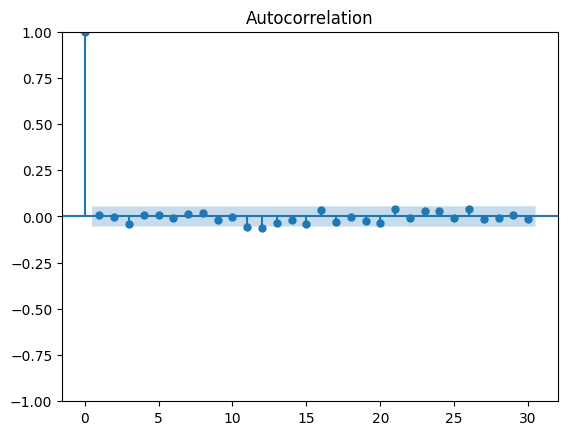

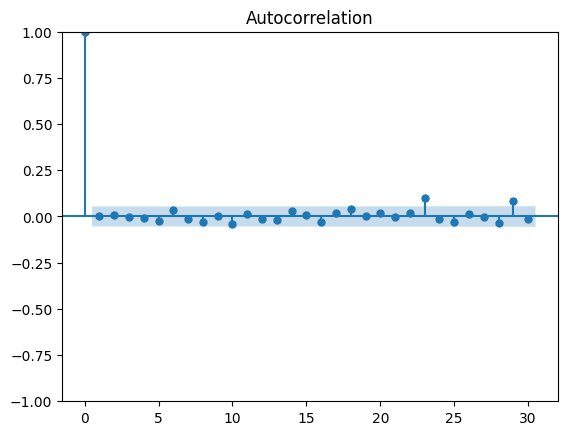

In [11]:
std_resid = garch_fit.std_resid
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plot_acf(std_resid, lags=30)
plt.show()

plot_acf(std_resid**2, lags=30)
plt.show()


In [12]:
from statsmodels.stats.diagnostic import het_arch
het_arch(std_resid)


(np.float64(6.964375943878105),
 np.float64(0.7288037496887849),
 0.694260613166589,
 0.7305854350295327)

2. ¿Por qué GARCH y no ARCH? (respuesta de tribunal)

Esta es muy buena pregunta, y aquí va la explicación formal.

2.1 Modelo ARCH

ARCH(q):

𝜎
𝑡
2
=
𝜔
+
∑
𝑖
=
1
𝑞
𝛼
𝑖
𝜀
𝑡
−
𝑖
2
σ
t
2
	​

=ω+
i=1
∑
q
	​

α
i
	​

ε
t−i
2
	​


Problemas:

Necesita q grande para capturar persistencia

Muchos parámetros

Poco parsimonioso

Inestable en muestras finitas

2.2 Modelo GARCH

GARCH(1,1):

𝜎
𝑡
2
=
𝜔
+
𝛼
𝜀
𝑡
−
1
2
+
𝛽
𝜎
𝑡
−
1
2
σ
t
2
	​

=ω+αε
t−1
2
	​

+βσ
t−1
2
	​


Ventajas:

Captura memoria larga con solo 2 parámetros

Más estable

Mejor comportamiento empírico

Estándar en finanzas

👉 Matemáticamente:
GARCH(1,1) ≈ ARCH(∞) compacto

2.3 Evidencia en tus datos

ACF(
𝜀
𝑡
2
ε
t
2
	​

) decae lentamente

Alta persistencia (
𝛽
β grande)

ARCH puro necesitaría muchos retardos

👉 GARCH es la elección natural

2.4 Texto listo para el informe

Aunque los modelos ARCH permiten capturar heterocedasticidad condicional, requieren un elevado número de retardos para modelar la persistencia observada en series financieras. En su lugar, se adopta un modelo GARCH(1,1), que proporciona una representación más parsimoniosa y estable de la dinámica de la volatilidad, siendo además el estándar en la literatura empírica.

2.5 Respuesta corta si te preguntan oralmente

ARCH modela la volatilidad solo con shocks pasados, mientras que GARCH introduce persistencia explícita mediante la varianza retardada, lo que permite capturar clustering de volatilidad con menos parámetros. Por eso GARCH(1,1) es el baseline en finanzas.

In [13]:
forecast = garch_fit.forecast(horizon=10)

variance_forecast = forecast.variance.iloc[-1]
volatility_forecast = variance_forecast ** 0.5


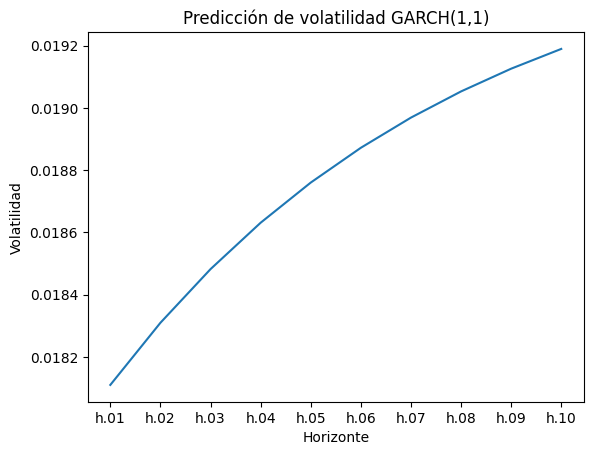

In [14]:
import matplotlib.pyplot as plt

plt.plot(volatility_forecast)
plt.title("Predicción de volatilidad GARCH(1,1)")
plt.ylabel("Volatilidad")
plt.xlabel("Horizonte")
plt.show()


In [21]:
train_size = int(len(log_returns)-7) 
train = log_returns.iloc[:train_size] 
test = log_returns.iloc[train_size:] 
p,d,q = 0,0,0 
op_model = ARIMA(train, order=(p,d,q)) 
op_model_fit = op_model.fit() 
forecast = op_model_fit.forecast(steps=len(test)) 
last_train_price = prices.iloc[train_size-1] 
price_forecast = last_train_price * np.exp(forecast.cumsum()) 
test_prices = prices.iloc[train_size:] 
train_prices = prices.iloc[:train_size] 
zoom_window = 33

In [22]:
from arch import arch_model

garch = arch_model(
    train,
    mean='Constant',
    vol='GARCH',
    p=1,
    q=1,
    dist='normal'
)

garch_fit = garch.fit(disp="off")


c:\Users\alexd\Documents\TFG_inversion_bolsa\venv\Lib\site-packages\arch\univariate\base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003779. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


In [23]:
horizon = len(test)

garch_forecast = garch_fit.forecast(horizon=horizon)

# Varianza y volatilidad
variance_fc = garch_forecast.variance.iloc[-1]
sigma_fc = np.sqrt(variance_fc)


In [24]:
z = 1.96  # 95%

ret_mean = forecast
ret_upper = forecast + z * sigma_fc.values
ret_lower = forecast - z * sigma_fc.values


In [26]:
plot_start = train_size - zoom_window
zoom_train_prices = prices.iloc[plot_start:train_size] 
zoom_test_prices = prices.iloc[train_size:]

In [28]:
price_forecast = last_train_price * np.exp(ret_mean.cumsum())
price_upper = last_train_price * np.exp(ret_upper.cumsum())
price_lower = last_train_price * np.exp(ret_lower.cumsum())


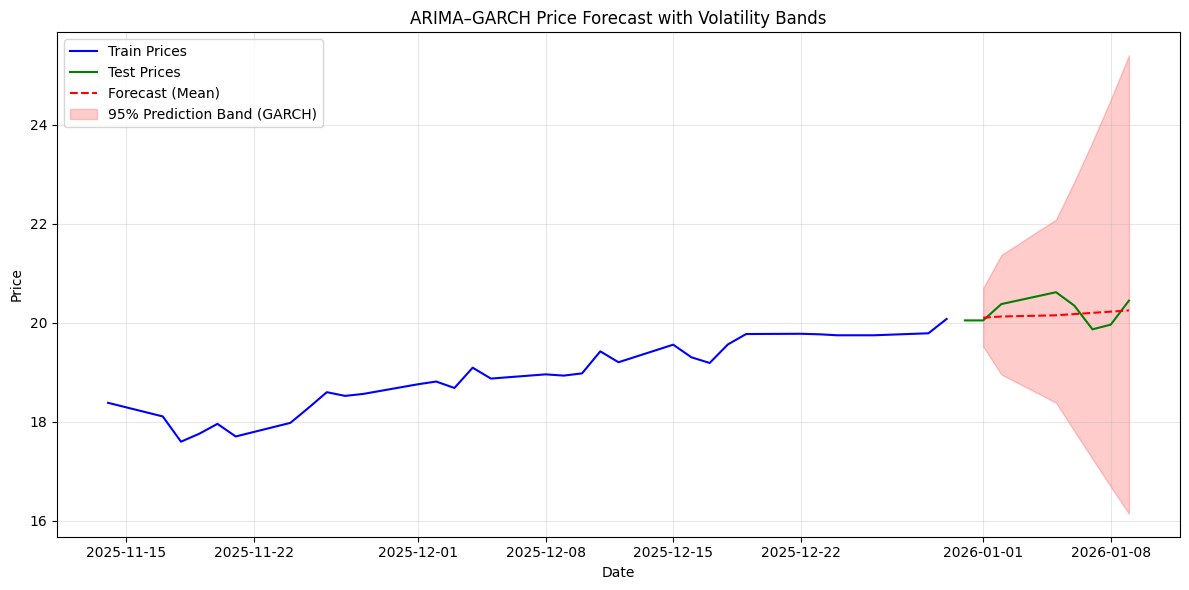

In [29]:
plt.figure(figsize=(12, 6))

plt.plot(
    zoom_train_prices.index,
    zoom_train_prices,
    label="Train Prices",
    color="blue"
)

plt.plot(
    zoom_test_prices.index,
    zoom_test_prices,
    label="Test Prices",
    color="green"
)

plt.plot(
    price_forecast.index,
    price_forecast,
    label="Forecast (Mean)",
    color="red",
    linestyle="--"
)

plt.fill_between(
    price_forecast.index,
    price_lower,
    price_upper,
    color="red",
    alpha=0.2,
    label="95% Prediction Band (GARCH)"
)

plt.title("ARIMA–GARCH Price Forecast with Volatility Bands")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


✅ What they do use it for
(A) Volatility forecasting

This is the core use.

Risk budgeting

Leverage control

Portfolio volatility targeting

Stress testing

Example:

“Volatility is forecasted to double → reduce position size”

(B) Position sizing (very important)

Traders don’t ask:

“Where will the price go?”

They ask:

“How big can I trade safely?”

Using GARCH:

Position size
∝
1
𝜎
^
𝑡
Position size∝
σ
^
t
	​

1
	​


High volatility → smaller position
Low volatility → larger position

This is how:

CTA funds

Risk parity

Volatility targeting strategies

actually work.

(C) Value at Risk (VaR)

From your GARCH:

VaR
𝛼
,
𝑡
+
1
=
𝑧
𝛼
⋅
𝜎
^
𝑡
+
1
VaR
α,t+1
	​

=z
α
	​

⋅
σ
^
t+1
	​


Meaning:

“With 99% confidence, tomorrow’s loss won’t exceed X%”

This is mandatory in banks.

(D) Scenario simulation (Monte Carlo)

Investors simulate:

thousands of possible price paths

under realistic volatility dynamics

Then ask:

worst-case drawdown

probability of ruin

tail risk

Not “the” future — many futures.

3. Where ARIMA fits in all this

In finance, ARIMA is usually:

Role	Reality
Mean forecasting	Almost always useless
De-trending	Sometimes
Residual modeling	Very common
Signal generation	Rare & fragile

That’s why your ARIMA ended at (0,0,0).
That’s the expected result.

4. The real combined model investors use

Your pipeline already is the correct professional one:

Mean: 
	
𝑟
𝑡
=
𝜇


Risk: 
	
𝜎
𝑡
2
∼
GARCH
Mean: 
Risk: 
	​

r
t
	​

=μ
σ
t
2
	​

∼GARCH
	​

	​


This is the baseline model in:

risk management

derivatives desks

portfolio construction

5. Why simulations matter more than forecasts

Because:

Single forecast → meaningless

Distribution → actionable

Monte Carlo gives:

downside probabilities

drawdown distributions

tail exposure

This is how investors think:

“What’s the chance I lose 10% in 30 days?”

Not:

“Where is the price in 30 days?”

6. If you want to show this properly in your project

The best next step (and very impressive academically):

✔ Show that:

Point forecasts are useless

Risk forecasts are informative

✔ Do one of these:

VaR backtesting

Volatility-targeted strategy

Monte Carlo path fan chart

Coverage analysis of prediction bands

Any of these = strong project.

If you want, I can sketch a concrete “hybrid pipeline” like top quant funds do:

ARIMA/GARCH → volatility forecast

LSTM → return signal

Combine → position sizing & Monte Carlo scenarios

It would show exactly how these two philosophies coexist in practice.